In [1]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from skimage import io, color, morphology, feature, measure, filters
from skimage.filters import gaussian, median
from skimage.restoration import denoise_bilateral
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt


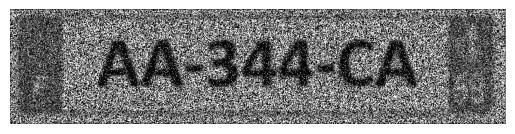

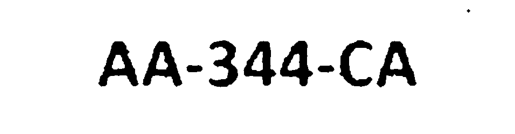

In [68]:
def get_image(path):
    # Charger l'image
    image = io.imread(path)
    # Vérifier le nombre de canaux
    if len(image.shape) == 3:  # Image avec plusieurs canaux
        if image.shape[2] == 2:  # Cas particulier avec 2 canaux
            image_gray = np.min(image, axis=2).astype(np.uint8)
        elif image.shape[2] == 3 or image.shape[2] == 4:  # Cas RGB ou RGBA
            image_gray = np.min(image[..., :3], axis=2).astype(np.uint8)  # Ignorer le canal alpha si RGBA
        else:
            raise ValueError("L'image a un nombre de canaux inattendu.")
    else:  # Image en niveaux de gris
        image_gray = image.astype(np.uint8)
    return image_gray

def smooth_image(image, method='gaussian', sigma=1):
    if method == 'gaussian':
        if image.ndim == 3:  # Si l'image a des canaux de couleur (RGB ou RGBA)
            return gaussian(image, sigma=sigma, channel_axis=-1)  # Utilise channel_axis pour les images couleur
        else:
            return gaussian(image, sigma=sigma)  # Pour les images en niveaux de gris
    elif method == 'median':
        return median_filter(image, size=2)  # Taille du voisinage pour le filtre médian
    else:
        raise ValueError(f"Méthode de lissage inconnue: {method}")



# path = 'images_horribles/images_horribles/plaque-004.png'
path = 'ressources/ressources/plaque-001.png'
im_plaque_1 = get_image(path)
plt.title('')
plt.imshow(im_plaque_1, cmap='gray')
plt.axis('off')
plt.show()

im_plaque_1_bin = im_plaque_1 > 100
# plt.imshow(im_plaque_1_bin, cmap='gray')
# plt.title('Binary')
# plt.show()


# Lissage avec le filtre médian
smoothed_image_median = smooth_image(im_plaque_1_bin, method='median')
# plt.title("Image lissée avec filtre médian")
# plt.imshow(smoothed_image_median, cmap='gray')
# plt.show()


nb_iteration = 1
smoothed_image_median = smooth_image(im_plaque_1_bin, method='median')
for i in range(nb_iteration):
    smoothed_image_median_new = smooth_image(smoothed_image_median, method='median')
    # plt.title(f"Image lissée avec filtre médian {i}")
    # plt.imshow(smoothed_image_median_new, cmap='gray')
    # plt.show()
    smoothed_image_median = smoothed_image_median_new
    # Nettoyage de l'image (suppression du bruit)
    cleaned = morphology.remove_small_objects(smoothed_image_median, min_size=50)
        
    # Dilation
    dilated_image = morphology.dilation(cleaned, morphology.square(6))

    # Afficher les résultats
    # plt.figure(figsize=(24, 12))
    # plt.subplot(2, 2, 1)
    # plt.title('Image Originale')
    # plt.imshow(smoothed_image_median, cmap='gray')
    # plt.axis('off')
    
    # plt.subplot(2, 2, 2)
    # plt.title('Image cleaned')
    # plt.imshow(cleaned, cmap='gray')
    # plt.axis('off')

    # plt.subplot(2, 2, 3)
    # plt.title('Image Après Dilatation')
    # plt.imshow(dilated_image, cmap='gray')
    # plt.axis('off')
    
    
    # Créer une image où le pixel est noir uniquement s'il est noir dans les deux images
    combined_image = np.logical_and(1- dilated_image, 1 - cleaned)

    # Afficher l'image combinée
    # plt.subplot(2, 2, 4)
    # plt.title('Pixels Noirs dans les Deux Images')
    # plt.imshow(1 - combined_image, cmap='gray')
    # plt.axis('off')


    plt.show()
    
final_image_memory = morphology.dilation(combined_image, morphology.square(1))
for i in range(3):
    final_image = morphology.binary_dilation(final_image_memory)
    final_image_memory = final_image
    
final_image =  1-final_image
plt.title('')
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.show()


# Base De Données - Plaques d'immatriculation

RW474ZB


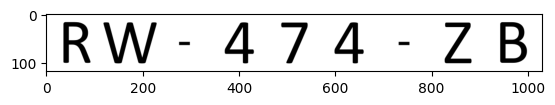

OR372OM


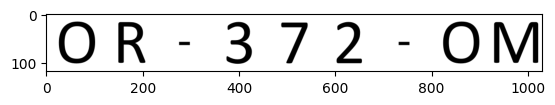

XF809KL


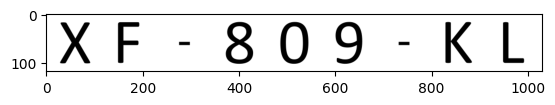

WT093PZ


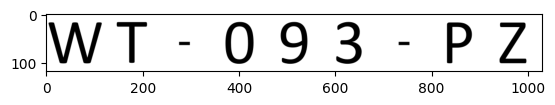

LB823MJ


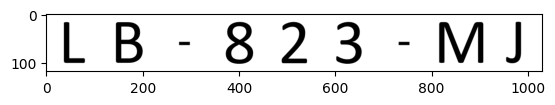

In [65]:
# Chemins des fichiers d'image
folder_lettres  = 'ressources/ressources/lettres/'
folder_chiffres = 'ressources/ressources/chiffres/'
path_tiret      = 'ressources/ressources/symboles/-.png'

def get_image(path_image):
    # Charger l'image
    image = io.imread(path_image)
    
    # Vérifier le nombre de canaux
    if len(image.shape) == 3:  # Image avec plusieurs canaux
        if image.shape[2] == 2:  # Cas particulier avec 2 canaux
            image_gray = np.min(image, axis=2).astype(np.uint8)
        elif image.shape[2] == 3 or image.shape[2] == 4:  # Cas RGB ou RGBA
            image_gray = np.min(image[..., :3], axis=2).astype(np.uint8)  # Ignorer le canal alpha si RGBA
        else:
            raise ValueError("L'image a un nombre de canaux inattendu.")
    else:  # Image en niveaux de gris
        image_gray = image.astype(np.uint8)
    return image_gray

def concat_images(image_1, image_2):    
    # Vérifier que les images ont la même hauteur
    if image_1.shape[0] != image_2.shape[0]:
        raise ValueError("Les images doivent avoir la même hauteur pour être concaténées horizontalement.")

    # On retire des colonnes pour que ça ressemble vrmt à des plaques d'immatriculation
    nb_colonne = 2
    image_1_cropped = image_1[:, :-nb_colonne]   # Retirer 20 colonnes à droite
    image_2_cropped = image_2[:, nb_colonne:]    # Retirer 20 colonnes à gauche

    # Concaténer horizontalement
    concatenated_image = np.concatenate((image_1_cropped, image_2_cropped), axis=1)
    return concatenated_image

def get_random_car(chaine):
    return random.choice(chaine)

chiffres = '0123456789'
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

def get_new_plaque():
    # PLAQUE = 2 LETTRES + 3 CHIFFRES + 2 LETTRES
    plaque_nom = ''
    image_tiret = get_image(path_tiret)
    
    # Ajout des 2 premières lettres
    new_lettre_1 = get_random_car(alphabet)
    plaque_nom += new_lettre_1
    path_lettre_1 = folder_lettres + new_lettre_1 + '.png'
    new_lettre_2 = get_random_car(alphabet)
    plaque_nom += new_lettre_2
    path_lettre_2 = folder_lettres + new_lettre_2 + '.png'
    
    # Charger les images des lettres individuellement
    image_1 = get_image(path_lettre_1)
    image_2 = get_image(path_lettre_2)
    
    plaque_image = concat_images(image_1, image_2)
    plaque_image = concat_images(plaque_image, image_tiret)
    
    # Ajout des 3 chiffres du milieu
    for i in range(3):
        new_chiffre = get_random_car(chiffres)
        plaque_nom += new_chiffre
        path_chiffre = folder_chiffres + new_chiffre + '.png'
        image_chiffre = get_image(path_chiffre)
        plaque_image = concat_images(plaque_image, image_chiffre)
    

    plaque_image = concat_images(plaque_image, image_tiret)
    
    # Ajout des 2 dernières lettres
    for i in range(2):
        new_lettre = get_random_car(alphabet)
        plaque_nom += new_lettre
        path_lettre = folder_lettres + new_lettre + '.png'
        image_lettre = get_image(path_lettre)
        plaque_image = concat_images(plaque_image, image_lettre)
        
    return plaque_image, plaque_nom


for i in range(5): 
    plaque_image, plaque_nom  = get_new_plaque()
    print(plaque_nom)
    plt.imshow(plaque_image, cmap='gray')
    plt.show()


